In [1]:
import zipfile
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Capstone/Data/'

Mounted at /content/drive


In [2]:
train_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx'
test_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/test.xlsx'
val_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx'

In [3]:
# Load the label data from the Excel files
train_df = pd.read_excel(train_labels_path)
test_df = pd.read_excel(test_labels_path)
val_df = pd.read_excel(val_labels_path)

In [4]:
test_df

,class,image
0,Pneumothorax,00030162_006_7823.png
1,Pneumothorax,00003126_007.png
2,Pneumothorax,00003468_007_2725.png
3,Pneumothorax,00002509_007_4660.png
4,Pneumothorax,00019201_002.png
...,...,...
19995,Cardiomegaly,00004893_073_1790.png
19996,Cardiomegaly,00004606_000_4273.png
19997,Cardiomegaly,00012081_000.png
19998,Cardiomegaly,00011139_000_4461.png


In [5]:
%%time
import zipfile
import concurrent.futures
zf = zipfile.ZipFile('/content/drive/My Drive/Capstone/Data/10Classes/Images.zip')
def unzip(file):
    zf.extract(file)
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 1min 21s, sys: 51.3 s, total: 2min 13s
Wall time: 1min 28s


In [6]:
import os

# Replace with the actual path to your images folder
images_folder_path = '/content/Images/Validation'

# List of image file extensions we're looking for
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

# Initialize a counter
image_count = 0

# Walk through all files and folders within the images folder
for root, dirs, files in os.walk(images_folder_path):
    for file in files:
        # Check if the file has one of the image file extensions
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

print(f'The folder contains {image_count} image(s).')


The folder contains 16000 image(s).


In [7]:
import os
import pandas as pd

# Define the paths to your image directories and annotation files
train_annotations_path = '/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx'
test_annotations_path = '/content/drive/My Drive/Capstone/Data/10Classes/test.xlsx'
validation_annotations_path = '/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx'

train_img_dir = '/content/Images/Train'
test_img_dir = '/content/Images/Test'
validation_img_dir = '/content/Images/Validation'

# A function to check if files exist
def check_images_exist(annotations_path, img_dir):
    # Read the annotations file
    df = pd.read_excel(annotations_path)
    # Assuming the Excel file has a column named 'filename' with the image file names
    missing_files = []
    for filename in df['image']:
        file_path = os.path.join(img_dir, filename)
        if not os.path.isfile(file_path):
            missing_files.append(filename)
    return missing_files

# Check each dataset
missing_train_files = check_images_exist(train_annotations_path, train_img_dir)
missing_test_files = check_images_exist(test_annotations_path, test_img_dir)
missing_validation_files = check_images_exist(validation_annotations_path, validation_img_dir)

# Report the results
if missing_train_files:
    print(f'Missing training files: {missing_train_files}')
else:
    print('All training files are present.')

if missing_test_files:
    print(f'Missing test files: {missing_test_files}')
else:
    print('All test files are present.')

if missing_validation_files:
    print(f'Missing validation files: {missing_validation_files}')
else:
    print('All validation files are present.')


All training files are present.
All test files are present.
All validation files are present.


In [8]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
      image = Image.open(img_path).convert('RGB')  # Convert image to RGB
      label = self.img_labels.iloc[idx, 0]
      # Convert the label from string to integer using the mapping dictionary
      label = class_to_idx[label]
      if self.transform:
          image = self.transform(image)
      return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx',
                                   img_dir='/content/Images/Train',
                                   transform=transform)

test_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/test.xlsx',
                                  img_dir='/content/Images/Test',
                                  transform=transform)

val_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx',
                                 img_dir='/content/Images/Validation',
                                 transform=transform)




class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_to_idx



from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)





In [9]:
class_to_idx

{'Effusion': 0,
 'Cardiomegaly': 1,
 'Pneumothorax': 2,
 'Pleural Thickening': 3,
 'Consolidation': 4,
 'No Finding': 5,
 'Mass': 6,
 'Nodule': 7,
 'Infiltration': 8,
 'Atelectasis': 9}

## FIRST MODEL

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
# Import the copy module
import copy

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_classes = 10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the GPU if available
model = model.to(device)

# Summary of the model (optional, it requires torchsummary to be installed)
# summary(model, input_size=(3, 224, 224))

# Assume the rest of the setup code above remains the same...

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_trained = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=15)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


train Loss: 1.9969 Acc: 0.2773
val Loss: 1.9309 Acc: 0.3099
train Loss: 1.7882 Acc: 0.3674
val Loss: 1.8205 Acc: 0.3565
train Loss: 1.6883 Acc: 0.4016
val Loss: 1.6910 Acc: 0.3982
train Loss: 1.6092 Acc: 0.4336
val Loss: 1.7201 Acc: 0.4061
train Loss: 1.5403 Acc: 0.4580
val Loss: 1.7029 Acc: 0.4088
train Loss: 1.4741 Acc: 0.4794
val Loss: 1.5626 Acc: 0.4522
train Loss: 1.4079 Acc: 0.5005
val Loss: 1.6184 Acc: 0.4476
train Loss: 1.2341 Acc: 0.5644
val Loss: 1.3372 Acc: 0.5281
train Loss: 1.1662 Acc: 0.5889
val Loss: 1.3060 Acc: 0.5428
train Loss: 1.1308 Acc: 0.6003
val Loss: 1.2711 Acc: 0.5527
train Loss: 1.1032 Acc: 0.6113
val Loss: 1.2615 Acc: 0.5586
train Loss: 1.0715 Acc: 0.6215
val Loss: 1.2447 Acc: 0.5648
train Loss: 1.0441 Acc: 0.6304
val Loss: 1.2073 Acc: 0.5799
train Loss: 1.0132 Acc: 0.6416
val Loss: 1.2096 Acc: 0.5812
train Loss: 0.9922 Acc: 0.6492
val Loss: 1.1812 Acc: 0.5824
Best val Acc: 0.5824


In [ ]:

# Save the model (optional)
torch.save(model_trained.state_dict(), '/content/drive/My Drive/Capstone/Data/10Classes/model_resnet50.pth')


# Save the model (optional)
# torch.save(model_trained.state_dict(), 'model_resnet50.pth')

# To evaluate on the test set
model.eval()
# Then loop over your test_loader


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
# Import the copy module
import copy

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (must be the same as when the model was saved)
num_classes = 10  # Make sure this is the same as when you trained the model
model = models.resnet50(pretrained=False)  # pretrained=False since we're loading our trained weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved weights
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Data/10Classes/model_resnet50.pth', map_location=device))

# Move the model to the GPU if available
model = model.to(device)

# Define your criterion here (should be the same as the one used during training)
criterion = nn.CrossEntropyLoss()

# Assuming your DataLoader is named 'test_loader'
# Replace 'your_test_loader' with the actual variable name of your test DataLoader

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    # No need to track gradients for validation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Update running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy over all test data
    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Evaluate the model using the test dataset
evaluate_model(model, test_loader, criterion)


Test Loss: 1.1981 Acc: 0.5853


##SECOND MODEL

In [ ]:
class_to_idx

{'Mass': 0,
 'Cardiomegaly': 1,
 'Atelectasis': 2,
 'Effusion': 3,
 'Pneumothorax': 4,
 'No Finding': 5,
 'Subcutaneous Emphysema': 6,
 'Nodule': 7,
 'Pleural Thickening': 8,
 'Edema': 9,
 'Pneumonia': 10,
 'Emphysema': 11,
 'Infiltration': 12,
 'Consolidation': 13,
 'Fibrosis': 14}

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a function to transform your labels
def target_transform(label):
    # Your code to transform the label if necessary, e.g., a class to index mapping
    return class_to_idx[label]



# Create datasets
train_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx',
    img_dir='/content/Images/Train',
    transform=transform,
    target_transform=target_transform
)

test_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/test.xlsx',
    img_dir='/content//Images/Test',
    transform=transform,
    target_transform=target_transform
)


# Create the validation dataset
val_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx',
    img_dir='/content/Images/Validation',
    transform=transform,
    target_transform=target_transform
)



# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 0]
        if self.target_transform:
            label = self.target_transform(label)
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a function or dictionary to transform your labels

def target_transform(label):
    return class_to_idx[label]

# Initialize datasets
train_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx',
    img_dir='/content/Images/Train',
    transform=data_transforms,
    target_transform=target_transform
)

val_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx',
    img_dir='/content/Images/Validation',
    transform=data_transforms,
    target_transform=target_transform
)

# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Assuming you have 15 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=15)




In [ ]:
# Save the model
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/Data/10Classes/model2_resnet50.pth')


In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Function to evaluate the model on the test set
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    final_loss = running_loss / total
    final_acc = running_corrects.double() / total
    print(f'Test set: Average loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}')


criterion = nn.CrossEntropyLoss()

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model architecture
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Update the next line with the correct number of output classes
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)

# Load the trained model state
model_ft.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Data/10Classes/model2_resnet50.pth'))

# Now you can evaluate your model
evaluate_model(model_ft, test_loader, criterion)



Test set: Average loss: 1.3686, Accuracy: 0.5177


## THIRD MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Assume the rest of the code above this is the same

# Initialize the model for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Adjust to your number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

# Training function - same as before, with modification to scheduler step
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=15)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


Epoch 1/15
----------
train Loss: 1.9191 Acc: 0.3112
val Loss: 1.8223 Acc: 0.3536
Epoch 2/15
----------
train Loss: 1.7371 Acc: 0.3829
val Loss: 1.7283 Acc: 0.3891
Epoch 3/15
----------
train Loss: 1.6517 Acc: 0.4161
val Loss: 1.6955 Acc: 0.4014
Epoch 4/15
----------
train Loss: 1.5727 Acc: 0.4465
val Loss: 1.6092 Acc: 0.4246
Epoch 5/15
----------
train Loss: 1.5030 Acc: 0.4705
val Loss: 1.5217 Acc: 0.4589
Epoch 6/15
----------
train Loss: 1.4426 Acc: 0.4891
val Loss: 1.5660 Acc: 0.4572
Epoch 7/15
----------
train Loss: 1.3709 Acc: 0.5132
val Loss: 1.5245 Acc: 0.4719
Epoch 8/15
----------
train Loss: 1.3098 Acc: 0.5357
val Loss: 1.5664 Acc: 0.4831
Epoch 9/15
----------
train Loss: 1.2472 Acc: 0.5582
val Loss: 1.3490 Acc: 0.5224
Epoch 10/15
----------
train Loss: 1.1978 Acc: 0.5737
val Loss: 1.3986 Acc: 0.5256
Epoch 11/15
----------
train Loss: 1.1520 Acc: 0.5921
val Loss: 1.3713 Acc: 0.5272
Epoch 12/15
----------
train Loss: 1.1028 Acc: 0.6082
val Loss: 1.2799 Acc: 0.5545
Epoch 13/15
-

In [ ]:
# Save the model
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/Data/10Classes/model3_resnet50.pth')


In [ ]:
class_to_idx

{'Effusion': 0,
 'Cardiomegaly': 1,
 'Pneumothorax': 2,
 'Pleural Thickening': 3,
 'Consolidation': 4,
 'No Finding': 5,
 'Mass': 6,
 'Nodule': 7,
 'Infiltration': 8,
 'Atelectasis': 9}

Test Loss: 1.2124 Acc: 0.5813


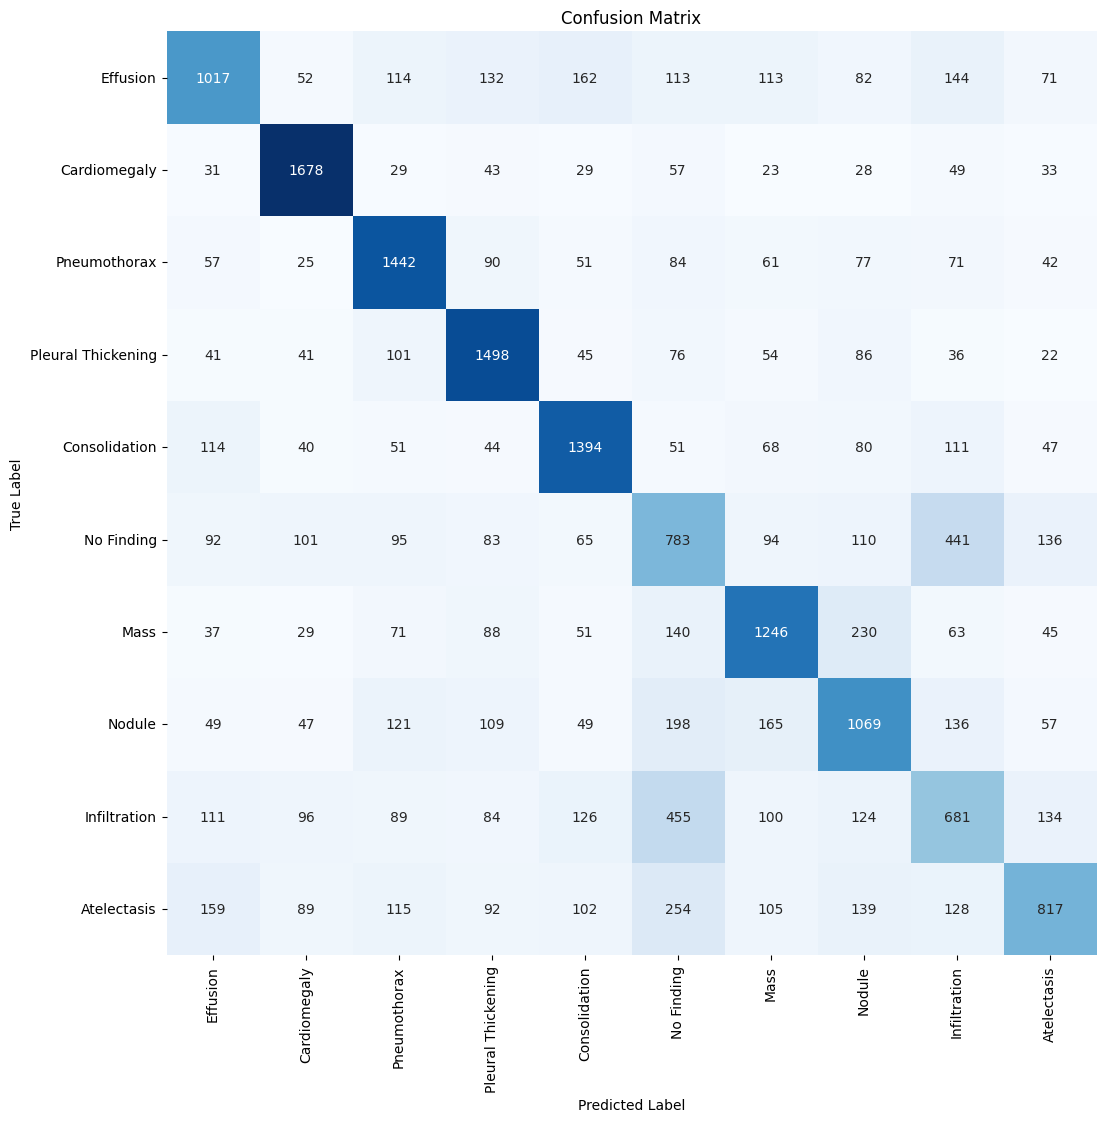

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")
    ax.set_xticklabels(class_names,rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    plt.show()

    return total_loss, total_acc, conf_matrix



#class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]


# Initialize the model architecture
model = models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Data/10Classes/model3_resnet50.pth'))

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Now you can proceed with the evaluation
test_loss, test_acc, conf_matrix = test_model(model, test_loader, criterion, class_names)


###THIRD MODEL UPGRADE (3.1)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy


# Assume the rest of the code above this is the same

# Initialize the model for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Adjust to your number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

# Training function - same as before, with modification to scheduler step
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=30)


Epoch 1/30
----------
train Loss: 1.9209 Acc: 0.3075
val Loss: 1.8163 Acc: 0.3508

Epoch 2/30
----------
train Loss: 1.7411 Acc: 0.3829
val Loss: 1.9007 Acc: 0.3554

Epoch 3/30
----------
train Loss: 1.6536 Acc: 0.4138
val Loss: 1.8376 Acc: 0.3879

Epoch 4/30
----------
train Loss: 1.5835 Acc: 0.4401
val Loss: 1.6439 Acc: 0.4202

Epoch 5/30
----------
train Loss: 1.5253 Acc: 0.4615
val Loss: 1.7645 Acc: 0.4261

Epoch 6/30
----------
train Loss: 1.4526 Acc: 0.4851
val Loss: 1.5301 Acc: 0.4582

Epoch 7/30
----------
train Loss: 1.3896 Acc: 0.5112
val Loss: 1.5370 Acc: 0.4643

Epoch 8/30
----------
train Loss: 1.3291 Acc: 0.5267
val Loss: 1.4440 Acc: 0.4914

Epoch 9/30
----------
train Loss: 1.2704 Acc: 0.5491
val Loss: 1.4024 Acc: 0.5031

Epoch 10/30
----------
train Loss: 1.2219 Acc: 0.5664
val Loss: 1.5384 Acc: 0.5021

Epoch 11/30
----------
train Loss: 1.1661 Acc: 0.5855
val Loss: 1.3365 Acc: 0.5367

Epoch 12/30
----------
train Loss: 1.1269 Acc: 0.5990
val Loss: 1.3802 Acc: 0.5294

E

In [21]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/Data/10Classes/model3.1_resnet50.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 1.0531 Acc: 0.6489


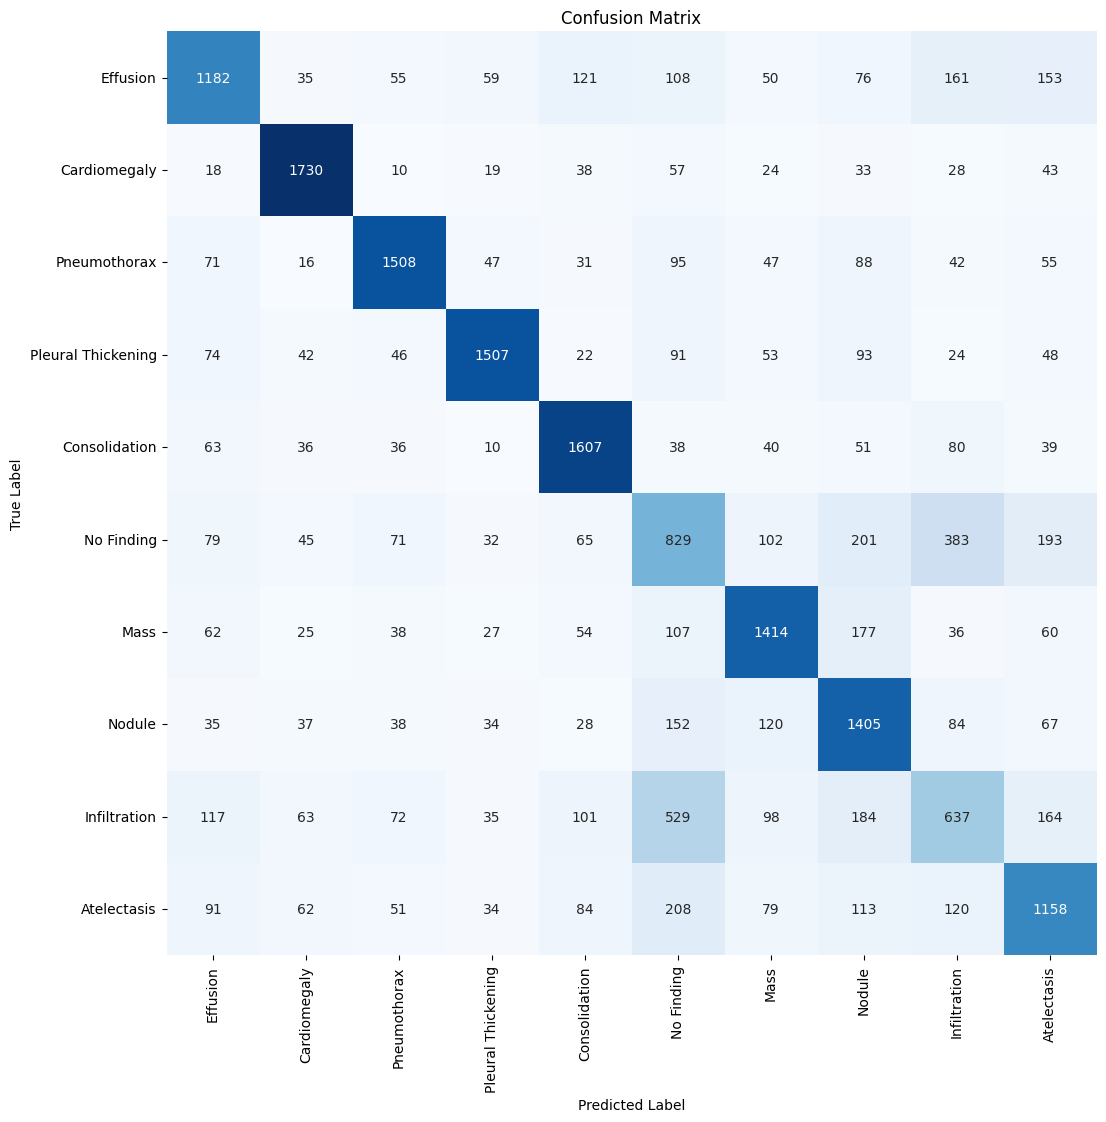

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")
    ax.set_xticklabels(class_names,rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    plt.show()

    return total_loss, total_acc, conf_matrix



#class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]


# Initialize the model architecture
model = models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Data/10Classes/model3.1_resnet50.pth'))

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Now you can proceed with the evaluation
test_loss, test_acc, conf_matrix = test_model(model, test_loader, criterion, class_names)


###THIRD MODEL UPGRADE(3.2)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Assume the rest of the code above this is the same

# Initialize the model for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Adjust to your number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Define class_to_idx mapping here
# class_to_idx = {'class1': 0, 'class2': 1, ...}

# Define your data loaders here
# train_loader = DataLoader(...)
# val_loader = DataLoader(...)

# Initialize the model for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Replace the last fully connected layer
# Note: len(class_to_idx) should be the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

# Training function with early stopping
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(train_loader.dataset) if phase == 'train' else len(val_loader.dataset))
            epoch_acc = running_corrects.double() / (len(train_loader.dataset) if phase == 'train' else len(val_loader.dataset))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

                # Check if the model improved
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model with early stopping
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=5)


Epoch 1/50
----------
train Loss: 1.9041 Acc: 0.3180
val Loss: 1.8151 Acc: 0.3511

Epoch 2/50
----------
train Loss: 1.7269 Acc: 0.3874
val Loss: 1.7238 Acc: 0.3857

Epoch 3/50
----------
train Loss: 1.6459 Acc: 0.4187
val Loss: 1.6590 Acc: 0.4147

Epoch 4/50
----------
train Loss: 1.5702 Acc: 0.4445
val Loss: 1.6559 Acc: 0.4149

Epoch 5/50
----------
train Loss: 1.5072 Acc: 0.4696
val Loss: 1.5609 Acc: 0.4415

Epoch 6/50
----------
train Loss: 1.4325 Acc: 0.4959
val Loss: 1.4956 Acc: 0.4705

Epoch 7/50
----------
train Loss: 1.3689 Acc: 0.5175
val Loss: 1.4479 Acc: 0.4859

Epoch 8/50
----------
train Loss: 1.3095 Acc: 0.5393
val Loss: 1.5287 Acc: 0.4793

Epoch 9/50
----------
train Loss: 1.2609 Acc: 0.5532
val Loss: 1.4043 Acc: 0.5079

Epoch 10/50
----------
train Loss: 1.2027 Acc: 0.5753
val Loss: 1.3493 Acc: 0.5286

Epoch 11/50
----------
train Loss: 1.1469 Acc: 0.5923
val Loss: 1.3839 Acc: 0.5300

Epoch 12/50
----------
train Loss: 1.1027 Acc: 0.6096
val Loss: 1.3155 Acc: 0.5404

E

KeyboardInterrupt: 

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/Data/10Classes/model3.2_resnet50.pth')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")
    ax.set_xticklabels(class_names,rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    plt.show()

    return total_loss, total_acc, conf_matrix



#class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]


# Initialize the model architecture
model = models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Data/10Classes/model3.2_resnet50.pth'))

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Now you can proceed with the evaluation
test_loss, test_acc, conf_matrix = test_model(model, test_loader, criterion, class_names)
